# Graph partitioning

## Introduction

With the ever increasing scale of graph data available, it is desirable that there are approaches to dividing the graph into meaningful partitions with a stream processing paradigm. The concept of a meaningful partition is dependent on the purpose to which the graph is put and if that is for visualisation by an end-user, then there are constraints on how many vertices can be shown at any one time. A further constraint could be the overall complexity of the graph, which encompasses the number of edges, the number of different types of vertices and how connected the vertices are.

One of difficulties with performing graph clustering using a streaming approach, e.g. in Apache Spark, is that the graph data may be read from a source system in a random order, especially if the data is obtained from a distributed storage system. The calculated graph partitions may be subject to further processing, such as statistical summarisation, and it is important for the partitions to be consistent across runs, whereby exactly the same partitions are produced each time irregardless of the order in which the data is streamed in.

Let a graph with $V$ vertices and $E$ edges be denoted $G(V,E)$. Graph parititioning algorithms typically divide the vertices of the graph $G$ into equal (or approximately) equal subsets where the number of edges connecting vertices in different partitions are minimised. The optimisation could be performed using numerical methods, such as simulated annealing, with a cost function that encodes the number of edges connecting vertices across differing partitions.

A bipartite or multipartite graph is composed vertices of different types. For example, a graph of academic papers and their authors could be represented as a bipartite graph with two types of vertices. If the academic institutions that the authors work for are added to the graph then there are three vertex types and so the graph is termed a multipartite graph.

## Graph partitioning with seed vertices

Suppose a bipartite or multipartite graph is to be partitioned such that the partitions are centred around selected vertices. Those vertices could be of a particular type or have some defining attribute. The vertices around which the partitions are formed are termed seed vertices.

### Nearest neighbour partitions

Possibly the simplest partitioning approach (other than the degenerate case of causing all vertices to be in the same partition) is to assign the nearest vertices to a seed vertex as belonging to that seed vertex's partition. Therefore, all vertices one hop from a seed vertex will be in the same partition. 

If a vertex is one hop away from two or more seed vertices then a selection mechanism is required. This could take the form of choosing the seed vertex that is connected to the vertex of interest by the edge with the lowest weight.

It should be noted that vertices that are more than one hop from a seed vertex will not be assigned a specific partition. All vertices will be assigned to a default partition and then they may be assigned a partition if they are within one hop of a seed vertex.

The advantage of the algorithm is that it can be implemented by processing each edge one at a time. It requires very limited storage of just a map of a seed vertex to the non-seed vertices to which it connects.

In [39]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import seaborn as sns

from collections import defaultdict

def palette(n_colours: int):
    """"Returns a palette of n_colours."""
    palette = np.round(np.array(sns.color_palette("viridis", n_colours)) * 255).astype(int)
    return ["#%02x%02x%02x" % (p[0], p[1], p[2]) for p in palette]

def random_weighted_graph(n: int, min_weight: int, max_weight: int, seed=None):
    """Make a random weighted graph with n nodes and integer weights."""

    # Build a random graph
    G = nx.barabasi_albert_graph(n=n, m=1, seed=seed)

    # Generate the edge weights
    weights = [random.randint(min_weight, max_weight) for _ in range(len(G.edges()))]

    # Build the weighted edges
    weighted_edges = [(src, dst, weights[idx]) for idx, (src, dst) in enumerate(G.edges())]

    # Build the weighted graph (note that adding the nodes in order is important
    # as otherwise the node colouring becomes more complex)
    G_weighted = nx.Graph()
    for node in G.nodes():
        G_weighted.add_node(node)

    G_weighted.add_weighted_edges_from(weighted_edges)

    # Check the weighted graph has been properly constructed
    assert G.edges() == G_weighted.edges()

    return G_weighted

In [ ]:
def plot_partitions(partitions):
    
    # Node colours
    colours = palette(n_seed_nodes + 1)
    seed_node_colours = {seed:colours[idx] for idx, seed in enumerate(seed_nodes)}

    node_colours = [colours[-1] for _ in G.nodes()]
    for seed, nodes in partitions.items():
        node_colours[seed] = seed_node_colours[seed]
        for node in nodes:
            node_colours[node] = seed_node_colours[seed]

    # Node labels
    node_labels = dict([
        (node,node) if node not in seed_nodes else (node,f"Seed {node}") for node in G.nodes()
    ])

    # Draw the graph and colour the nodes by the partition to which they are assigned
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=node_colours, labels=node_labels, with_labels=True)

    # Add the edge weights
    edge_labels = {(src, dst):G.get_edge_data(src, dst)['weight'] for src,dst in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.show()

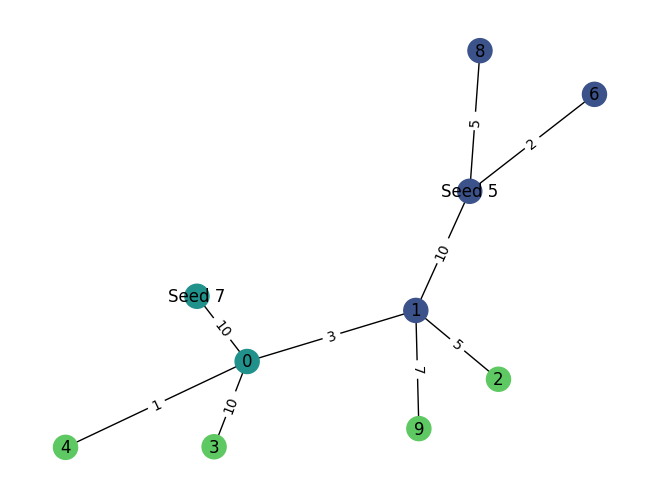

In [ ]:
from itertools import chain

# Build a random weighted graph
G = random_weighted_graph(n=10, min_weight=1, max_weight=10, seed=1234)

# Number of seed nodes
n_seed_nodes = max(2, len(G.nodes()) / 10)

# Randomly select the seed nodes
random.seed(1232)
seed_nodes = set(random.choices(list(G.nodes()), k=2))
assert len(seed_nodes) == n_seed_nodes

# Shuffle the edges
edges = list(G.edges())
random.shuffle(edges)

# Partition the graph
unpartitioned_nodes = []
partitions = defaultdict(set)

for source, destination in edges:

    # Set of nodes that have already been assigned to partitions
    assigned_nodes = set(chain.from_iterable(list(partitions.values())))

    if source in seed_nodes and destination not in assigned_nodes:
        partitions[source].add(destination)

    if destination in seed_nodes and source not in assigned_nodes:
        partitions[destination].add(source)

# Node colours
colours = palette(n_seed_nodes + 1)
seed_node_colours = {seed:colours[idx] for idx, seed in enumerate(seed_nodes)}

node_colours = [colours[-1] for _ in G.nodes()]
for seed, nodes in partitions.items():
    node_colours[seed] = seed_node_colours[seed]
    for node in nodes:
        node_colours[node] = seed_node_colours[seed]

# Node labels
node_labels = dict([
    (node,node) if node not in seed_nodes else (node,f"Seed {node}") for node in G.nodes()
])

# Draw the graph and colour the nodes by the partition to which they are assigned
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color=node_colours, labels=node_labels, with_labels=True)

# Add the edge weights
edge_labels = {(src, dst):G.get_edge_data(src, dst)['weight'] for src,dst in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

### n-degree separation partitions

Whereas the nearest neighbour partitions approach causes vertices to be assigned to partitions based on a single connection, it could be extended to multiple hops. A single hop is a single degree of separation and so $n \in \mathbb{Z}$ hops would be n-degrees of separation.

The challenge with this approach compared to the nearest neighbour approach is that it requires more storage as it is not possible to determine the partition of a vertex given a single edge.

In [ ]:
# Build a random weighted graph
G = random_weighted_graph(n=10, min_weight=1, max_weight=10, seed=1234)

# Number of seed nodes
n_seed_nodes = max(2, len(G.nodes()) / 10)

# Randomly select the seed nodes
random.seed(1232)
seed_nodes = set(random.choices(list(G.nodes()), k=2))
assert len(seed_nodes) == n_seed_nodes

# Shuffle the edges
edges = list(G.edges())
random.shuffle(edges)

# Partition the graph
edge_used = [False for _ in range(len(G.edges()))]
partition_to_edges = defaultdict(set)
change_in_iteration = True

while not change_in_iteration:

    change_in_iteration = False
    for edge_idx, edge_used in enumerate(edge_used):
        if edge_used:
            continue

        


for source, destination in edges:
    pass

### Shortest path partitions